# Model training for `Quora Question pair similarity`

For **2nd iteration**. Use Featured data (generated from `feature_engineering_test` and `feature_engineering_train`) for Model Training

- Get the featured train and test data from corresponding files
- Put train and test data into modeling
- Get results and submissions
- Input: 
  - vectors feature from `final_features.csv` as well as test_data version (because en_core_web_md will run out of memory in my laptop, so i use the vector features from en_core_web_sm that i saved before)
  - `feature_tm.csv` as well as test_data version (contains train.csv)
  - `feature_nlp.csv` as well as test_data version
- Ouput: models in `Models/`

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
import time
import warnings
import sqlite3
from sqlalchemy import create_engine # database connection
import csv
import os
warnings.filterwarnings("ignore")
import datetime as dt
import numpy as np
from nltk.corpus import stopwords
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import normalize
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.manifold import TSNE
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics.classification import accuracy_score, log_loss
from sklearn.feature_extraction.text import TfidfVectorizer
from collections import Counter
from scipy.sparse import hstack
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold 
from collections import Counter, defaultdict
from sklearn.calibration import CalibratedClassifierCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
import math
from sklearn.metrics import normalized_mutual_info_score
from sklearn.ensemble import RandomForestClassifier



from sklearn.model_selection import cross_val_score
from sklearn.linear_model import SGDClassifier
from mlxtend.classifier import StackingClassifier

from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_recall_curve, auc, roc_curve

## Load Training data 

### Load training features from csv file

In [2]:
# Load vector features from final_features.csv (becasue it is the same (all used spacy_en_core_web_sm))

data_csv = pd.read_csv('final_features.csv')
data_csv.head()

,Unnamed: 0,id,is_duplicate,cwc_min,cwc_max,csc_min,csc_max,ctc_min,ctc_max,last_word_eq,...,86_y,87_y,88_y,89_y,90_y,91_y,92_y,93_y,94_y,95_y
0,0,0,0,0.999980,0.833319,0.999983,0.999983,0.916659,0.785709,0.0,...,15.591466,96.113849,31.001480,-44.172052,21.397091,-46.908810,-100.162247,-1.978221,38.112752,-11.592531
1,1,1,0,0.799984,0.399996,0.749981,0.599988,0.699993,0.466664,0.0,...,-84.838611,54.099417,-65.543286,-23.634332,-85.303453,33.143694,-65.774337,28.145018,-22.243213,0.169092
2,2,2,0,0.399992,0.333328,0.399992,0.249997,0.399996,0.285712,0.0,...,27.926253,33.117176,66.706154,50.397498,42.266215,-29.920099,-53.378103,-31.755547,77.061497,9.438696
3,3,3,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,...,-7.491278,44.788221,6.437781,39.981581,-43.237003,39.471643,-0.322382,-6.074735,-4.417220,5.627428
4,4,4,0,0.399992,0.199998,0.999950,0.666644,0.571420,0.307690,0.0,...,44.084751,37.174410,0.356843,-29.468567,33.367771,-12.860933,-44.425541,3.958389,-13.291972,-9.029029


In [3]:
# get training labels 

y_true = data_csv['is_duplicate']
len(y_true)


404290

In [4]:
# Drop unecessary columns

columns_drop = []
columns_drop.append(data_csv.columns[0])
columns_drop += data_csv.columns[2:29].tolist()
print("These are the columns to be dropped", columns_drop)

df_vectors = data_csv.drop(columns=columns_drop,axis=1)
df_vectors


These are the columns to be dropped ['Unnamed: 0', 'is_duplicate', 'cwc_min', 'cwc_max', 'csc_min', 'csc_max', 'ctc_min', 'ctc_max', 'last_word_eq', 'first_word_eq', 'abs_len_diff', 'mean_len', 'token_set_ratio', 'token_sort_ratio', 'fuzz_ratio', 'fuzz_partial_ratio', 'longest_substr_ratio', 'freq_qid1', 'freq_qid2', 'q1len', 'q2len', 'q1_n_words', 'q2_n_words', 'word_Common', 'word_Total', 'word_share', 'freq_q1+q2', 'freq_q1-q2']


,id,0_x,1_x,2_x,3_x,4_x,5_x,6_x,7_x,8_x,...,86_y,87_y,88_y,89_y,90_y,91_y,92_y,93_y,94_y,95_y
0,0,78.682992,87.635912,77.898819,-61.473692,44.053226,18.525178,-28.609312,47.452460,-86.095610,...,15.591466,96.113849,31.001480,-44.172052,21.397091,-46.908810,-100.162247,-1.978221,38.112752,-11.592531
1,1,99.993008,55.174564,-2.049167,36.677249,85.412371,-45.989080,31.112590,76.453094,-74.456509,...,-84.838611,54.099417,-65.543286,-23.634332,-85.303453,33.143694,-65.774337,28.145018,-22.243213,0.169092
2,2,62.709638,72.489519,10.889310,-45.772860,71.261772,-34.385969,-26.228285,18.224490,-113.496336,...,27.926253,33.117176,66.706154,50.397498,42.266215,-29.920099,-53.378103,-31.755547,77.061497,9.438696
3,3,35.006791,-40.413219,53.450493,-45.069038,37.137247,-21.992808,-28.184323,131.916699,41.891510,...,-7.491278,44.788221,6.437781,39.981581,-43.237003,39.471643,-0.322382,-6.074735,-4.417220,5.627428
4,4,135.425154,187.445625,143.612776,-111.735024,56.977977,-70.101866,-47.585533,59.575895,-56.992457,...,44.084751,37.174410,0.356843,-29.468567,33.367771,-12.860933,-44.425541,3.958389,-13.291972,-9.029029
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
404285,404285,59.267353,53.308570,59.214630,-41.510235,134.183171,-44.156874,-158.025249,35.570810,-76.939342,...,39.309001,15.758037,36.746870,-57.793078,75.146161,-20.305723,-19.072270,-2.160282,105.635542,-16.815833
404286,404286,-22.483616,15.514055,44.191165,-43.024130,33.000220,48.886315,-33.129761,-27.532968,-22.914073,...,6.886801,30.711425,-32.673037,28.673688,82.408519,-10.283080,46.515741,-55.934617,8.210074,-22.594306
404287,404287,8.086156,13.003350,1.550075,-37.361558,-6.396335,-9.639999,21.519365,-3.257762,-17.741784,...,5.319683,20.635684,-8.970818,3.478943,17.787663,-7.907412,-10.202242,-34.997149,15.290493,5.483173
404288,404288,98.757430,34.897575,15.768073,-149.475133,82.196690,-83.929605,-80.157925,11.396484,-116.004433,...,45.423385,94.190066,64.764972,-76.355071,-26.776399,29.434206,-67.713252,4.832993,-63.650805,-5.479479


In [5]:
# Load features from features_tm.csv and features_nlp.csv

df_tm = pd.read_csv('Features/feature_tm.csv')
df_nlp = pd.read_csv('Features/feature_nlp.csv')


In [6]:
df_tm

,id,qid1,qid2,question1,question2,is_duplicate,q1len,q2len,diff_len,len_word_q1,...,len_char_q1,len_char_q2,diff_len_char,avg_world_len1,avg_world_len2,diff_avg_word,word_Common,word_Total,word_share,share_2_gram
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0,66,57,9,14,...,53,46,7,3.785714,3.833333,-0.047619,10.0,23.0,0.434783,0.416667
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0,51,88,-37,8,...,44,76,-32,5.500000,5.846154,-0.346154,4.0,20.0,0.200000,0.052632
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0,73,59,14,14,...,60,50,10,4.285714,5.000000,-0.714286,4.0,24.0,0.166667,0.045455
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0,50,65,-15,11,...,40,57,-17,3.636364,6.333333,-2.696970,0.0,19.0,0.000000,0.000000
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0,76,39,37,13,...,64,33,31,4.923077,4.714286,0.208791,2.0,20.0,0.100000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
404285,404285,433578,379845,How many keywords are there in the Racket prog...,How many keywords are there in PERL Programmin...,0,85,79,6,14,...,72,67,5,5.142857,5.153846,-0.010989,11.0,25.0,0.440000,0.360000
404286,404286,18840,155606,Do you believe there is life after death?,Is it true that there is life after death?,1,41,42,-1,8,...,34,34,0,4.250000,3.777778,0.472222,5.0,16.0,0.312500,0.266667
404287,404287,537928,537929,What is one coin?,What's this coin?,0,17,17,0,4,...,14,15,-1,3.500000,5.000000,-1.500000,1.0,7.0,0.142857,0.000000
404288,404288,537930,537931,What is the approx annual cost of living while...,I am having little hairfall problem but I want...,0,94,127,-33,17,...,78,103,-25,4.588235,4.120000,0.468235,1.0,40.0,0.025000,0.000000


In [7]:
df_nlp

,id,cwc_min,cwc_max,csc_min,csc_max,ctc_min,ctc_max,last_word_eq,first_word_eq,abs_len_diff,...,token_sort_ratio,fuzz_ratio,fuzz_partial_ratio,longest_substr_ratio,word_mover_dist,cosine_dist,cityblock_dist,canberra_dist,euclidean_dist,minkowski_dist
0,0,0.999980,0.833319,0.999983,0.999983,0.916659,0.785709,0.0,1.0,2.0,...,93,93,100,0.982759,1.216034,0.031762,14.274065,91.483062,1.047253,1.047253
1,1,0.799984,0.399996,0.749981,0.599988,0.699993,0.466664,0.0,1.0,5.0,...,63,66,75,0.596154,4.897662,0.266555,33.272633,149.670092,2.624989,2.624989
2,2,0.399992,0.333328,0.399992,0.249997,0.399996,0.285712,0.0,1.0,4.0,...,63,43,47,0.166667,4.011556,0.118900,28.457512,129.214660,2.140298,2.140298
3,3,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,2.0,...,24,9,14,0.039216,7.514702,0.619671,62.016426,200.899534,4.702347,4.702347
4,4,0.399992,0.199998,0.999950,0.666644,0.571420,0.307690,0.0,1.0,6.0,...,47,35,56,0.175000,6.257260,0.244168,40.127296,156.627744,3.145122,3.145122
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
404285,404285,0.857131,0.857131,0.999980,0.833319,0.846147,0.785709,1.0,1.0,1.0,...,88,91,87,0.387500,1.351202,0.061603,18.532461,110.665066,1.351204,1.351204
404286,404286,0.666644,0.666644,0.599988,0.599988,0.624992,0.555549,1.0,0.0,1.0,...,69,72,76,0.642857,1.518507,0.047257,20.919132,104.808199,1.518508,1.518508
404287,404287,0.999900,0.499975,0.999950,0.666644,0.749981,0.749981,1.0,1.0,0.0,...,79,79,76,0.444444,3.399536,0.114690,45.974075,124.490252,3.399536,3.399536
404288,404288,0.000000,0.000000,0.124998,0.099999,0.058823,0.040000,0.0,0.0,8.0,...,35,30,34,0.052632,8.156665,0.569064,50.616547,219.051497,3.740317,3.740317


In [8]:
# Merge features

import numpy as np

df_features = df_tm.merge(df_nlp, on='id', how='left')
df_features = df_features.merge(df_vectors, on='id', how='left')

df_features

,id,qid1,qid2,question1,question2,is_duplicate,q1len,q2len,diff_len,len_word_q1,...,86_y,87_y,88_y,89_y,90_y,91_y,92_y,93_y,94_y,95_y
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0,66,57,9,14,...,15.591466,96.113849,31.001480,-44.172052,21.397091,-46.908810,-100.162247,-1.978221,38.112752,-11.592531
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0,51,88,-37,8,...,-84.838611,54.099417,-65.543286,-23.634332,-85.303453,33.143694,-65.774337,28.145018,-22.243213,0.169092
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0,73,59,14,14,...,27.926253,33.117176,66.706154,50.397498,42.266215,-29.920099,-53.378103,-31.755547,77.061497,9.438696
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0,50,65,-15,11,...,-7.491278,44.788221,6.437781,39.981581,-43.237003,39.471643,-0.322382,-6.074735,-4.417220,5.627428
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0,76,39,37,13,...,44.084751,37.174410,0.356843,-29.468567,33.367771,-12.860933,-44.425541,3.958389,-13.291972,-9.029029
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
404285,404285,433578,379845,How many keywords are there in the Racket prog...,How many keywords are there in PERL Programmin...,0,85,79,6,14,...,39.309001,15.758037,36.746870,-57.793078,75.146161,-20.305723,-19.072270,-2.160282,105.635542,-16.815833
404286,404286,18840,155606,Do you believe there is life after death?,Is it true that there is life after death?,1,41,42,-1,8,...,6.886801,30.711425,-32.673037,28.673688,82.408519,-10.283080,46.515741,-55.934617,8.210074,-22.594306
404287,404287,537928,537929,What is one coin?,What's this coin?,0,17,17,0,4,...,5.319683,20.635684,-8.970818,3.478943,17.787663,-7.907412,-10.202242,-34.997149,15.290493,5.483173
404288,404288,537930,537931,What is the approx annual cost of living while...,I am having little hairfall problem but I want...,0,94,127,-33,17,...,45.423385,94.190066,64.764972,-76.355071,-26.776399,29.434206,-67.713252,4.832993,-63.650805,-5.479479


In [9]:
# Drop unecessary columns

df_features = df_features.drop(['id','qid1','qid2','question1','question2','is_duplicate'], axis=1)
type(df_features)

pandas.core.frame.DataFrame

In [10]:
df_features

,q1len,q2len,diff_len,len_word_q1,len_word_q2,diff_words,caps_count_q1,caps_count_q2,diff_caps,len_char_q1,...,86_y,87_y,88_y,89_y,90_y,91_y,92_y,93_y,94_y,95_y
0,66,57,9,14,12,2,1,1,0,53,...,15.591466,96.113849,31.001480,-44.172052,21.397091,-46.908810,-100.162247,-1.978221,38.112752,-11.592531
1,51,88,-37,8,13,-5,5,5,0,44,...,-84.838611,54.099417,-65.543286,-23.634332,-85.303453,33.143694,-65.774337,28.145018,-22.243213,0.169092
2,73,59,14,14,10,4,5,5,0,60,...,27.926253,33.117176,66.706154,50.397498,42.266215,-29.920099,-53.378103,-31.755547,77.061497,9.438696
3,50,65,-15,11,9,2,4,1,3,40,...,-7.491278,44.788221,6.437781,39.981581,-43.237003,39.471643,-0.322382,-6.074735,-4.417220,5.627428
4,76,39,37,13,7,6,1,1,0,64,...,44.084751,37.174410,0.356843,-29.468567,33.367771,-12.860933,-44.425541,3.958389,-13.291972,-9.029029
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
404285,85,79,6,14,13,1,2,7,-5,72,...,39.309001,15.758037,36.746870,-57.793078,75.146161,-20.305723,-19.072270,-2.160282,105.635542,-16.815833
404286,41,42,-1,8,9,-1,1,1,0,34,...,6.886801,30.711425,-32.673037,28.673688,82.408519,-10.283080,46.515741,-55.934617,8.210074,-22.594306
404287,17,17,0,4,3,1,1,1,0,14,...,5.319683,20.635684,-8.970818,3.478943,17.787663,-7.907412,-10.202242,-34.997149,15.290493,5.483173
404288,94,127,-33,17,25,-8,6,4,2,78,...,45.423385,94.190066,64.764972,-76.355071,-26.776399,29.434206,-67.713252,4.832993,-63.650805,-5.479479


In [11]:
# Check for na values

df_features.isna().sum()


q1len          0
q2len          0
diff_len       0
len_word_q1    0
len_word_q2    0
              ..
91_y           0
92_y           0
93_y           0
94_y           0
95_y           0
Length: 232, dtype: int64

In [12]:
# Prepare the training data
# Here, x_train means training data, y_train means training labels

data_train = df_features

# Change datatype to float64
cols_csv = list(data_train.columns)
x_train = pd.DataFrame(np.array(data_train.values,dtype=np.float64),columns=cols_csv)
y_train = list(map(int, y_true.values))

print(x_train.shape) 
print(len(y_train))

(404290, 232)
404290


## Load Testing data 

In [13]:
import pandas as pd
import matplotlib.pyplot as plt
import re
import time
import warnings
import sqlite3
from sqlalchemy import create_engine # database connection
import csv
import os
warnings.filterwarnings("ignore")
import datetime as dt
import numpy as np
from nltk.corpus import stopwords
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import normalize
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.manifold import TSNE
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics.classification import accuracy_score, log_loss
from sklearn.feature_extraction.text import TfidfVectorizer
from collections import Counter
from scipy.sparse import hstack
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold 
from collections import Counter, defaultdict
from sklearn.calibration import CalibratedClassifierCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
import math
from sklearn.metrics import normalized_mutual_info_score
from sklearn.ensemble import RandomForestClassifier



from sklearn.model_selection import cross_val_score
from sklearn.linear_model import SGDClassifier
from mlxtend.classifier import StackingClassifier

from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_recall_curve, auc, roc_curve

In [14]:
# Load vector features from final_features_test.csv

df_csv_test = pd.read_csv('final_features_test.csv')
df_csv_test.head()

,Unnamed: 0,test_id,cwc_min,cwc_max,csc_min,csc_max,ctc_min,ctc_max,last_word_eq,first_word_eq,...,86_y,87_y,88_y,89_y,90_y,91_y,92_y,93_y,94_y,95_y
0,0,0,0.599988,0.333330,0.000000,0.000000,0.272725,0.214284,0.0,0.0,...,-21.593862,38.256287,125.235087,-71.082921,-37.907017,-13.690217,58.171292,-55.596645,-55.454169,-75.937598
1,1,1,0.799984,0.571420,0.499975,0.142855,0.714276,0.357140,0.0,0.0,...,48.717889,9.306832,24.809384,-20.934689,6.793559,-14.271887,-37.130707,-7.595230,-88.665843,58.211807
2,2,2,0.999967,0.499992,0.666644,0.333328,0.833319,0.357140,0.0,1.0,...,-7.813350,31.216904,-33.981025,15.482006,33.123219,-46.651486,-44.865544,-15.787556,3.551124,-35.459945
3,3,3,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,...,13.824126,-1.324442,-3.411341,26.860650,19.679464,-25.372123,18.991221,-28.173208,-28.481408,-20.523815
4,4,4,0.999950,0.666644,0.999900,0.249994,0.749981,0.499992,1.0,1.0,...,13.318343,47.191545,-28.551520,14.815438,7.754977,-24.543755,15.449343,14.026138,-13.704267,1.230104


In [15]:
df_csv_test.shape

(2345796, 216)

In [16]:
columns_drop = []
columns_drop.append(df_csv_test.columns[0])
columns_drop += df_csv_test.columns[2:24].tolist()
columns_drop

['Unnamed: 0',
 'cwc_min',
 'cwc_max',
 'csc_min',
 'csc_max',
 'ctc_min',
 'ctc_max',
 'last_word_eq',
 'first_word_eq',
 'abs_len_diff',
 'mean_len',
 'token_set_ratio',
 'token_sort_ratio',
 'fuzz_ratio',
 'fuzz_partial_ratio',
 'longest_substr_ratio',
 'q1len',
 'q2len',
 'q1_n_words',
 'q2_n_words',
 'word_Common',
 'word_Total',
 'word_share']

In [17]:
# Drop unecessary columns

print("These are the columns to be dropped", columns_drop)

df_vectors_test = df_csv_test.drop(columns=columns_drop,axis=1)
df_vectors_test


These are the columns to be dropped ['Unnamed: 0', 'cwc_min', 'cwc_max', 'csc_min', 'csc_max', 'ctc_min', 'ctc_max', 'last_word_eq', 'first_word_eq', 'abs_len_diff', 'mean_len', 'token_set_ratio', 'token_sort_ratio', 'fuzz_ratio', 'fuzz_partial_ratio', 'longest_substr_ratio', 'q1len', 'q2len', 'q1_n_words', 'q2_n_words', 'word_Common', 'word_Total', 'word_share']


,test_id,0_x,1_x,2_x,3_x,4_x,5_x,6_x,7_x,8_x,...,86_y,87_y,88_y,89_y,90_y,91_y,92_y,93_y,94_y,95_y
0,0,57.807789,94.655806,29.802077,-64.234154,-9.277694,-49.877824,51.511347,112.852898,-0.087203,...,-21.593862,38.256287,125.235087,-71.082921,-37.907017,-13.690217,58.171292,-55.596645,-55.454169,-75.937598
1,1,12.897124,21.283125,17.126591,-105.457273,-10.864314,9.629620,3.914955,23.181845,-81.248861,...,48.717889,9.306832,24.809384,-20.934689,6.793559,-14.271887,-37.130707,-7.595230,-88.665843,58.211807
2,2,3.807019,-3.833035,-39.952575,-79.576704,-19.552001,-17.994014,-3.919386,48.652988,-65.372602,...,-7.813350,31.216904,-33.981025,15.482006,33.123219,-46.651486,-44.865544,-15.787556,3.551124,-35.459945
3,3,44.253134,41.788371,30.544037,-32.077580,20.291117,-27.602314,-89.614907,17.382471,34.562031,...,13.824126,-1.324442,-3.411341,26.860650,19.679464,-25.372123,18.991221,-28.173208,-28.481408,-20.523815
4,4,41.461432,11.422008,21.981641,-55.688798,18.130983,22.543548,-28.407952,36.844785,-39.443902,...,13.318343,47.191545,-28.551520,14.815438,7.754977,-24.543755,15.449343,14.026138,-13.704267,1.230104
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2345791,2345791,228.731106,104.746842,-57.442300,-16.162305,21.670765,39.921378,50.411566,60.130216,-100.895589,...,-6.679493,23.924009,30.597405,-18.275257,27.869585,-29.048751,-27.496907,-34.687108,44.871046,10.727710
2345792,2345792,29.222880,27.854141,56.975427,-27.627264,61.650519,20.190016,0.443094,23.269028,-98.235153,...,41.440152,36.256396,-1.368300,12.766321,34.625701,-25.969023,49.036330,-6.706774,-16.389284,-0.464075
2345793,2345793,68.999537,3.775822,82.420922,10.426870,168.312224,-99.611023,-99.559872,47.456131,-93.908065,...,12.216981,-61.148416,79.744077,43.598469,-14.981477,4.705598,3.571221,-35.909301,-11.514811,48.422906
2345794,2345794,57.997157,74.850758,40.953900,-46.138095,169.582994,-27.356493,35.563104,133.954845,-114.574158,...,-16.540529,-3.308689,57.458570,-29.407048,-43.692863,18.950830,-39.525612,-18.396463,32.254940,-43.880963


In [18]:
# Load features from features_tm_test.csv and features_nlp_test.csv

df_tm_test = pd.read_csv('Features/feature_tm_test.csv')
df_nlp_test = pd.read_csv('Features/feature_nlp_test.csv')


In [19]:
df_tm_test

,test_id,question1,question2,q1len,q2len,diff_len,len_word_q1,len_word_q2,diff_words,caps_count_q1,...,len_char_q1,len_char_q2,diff_len_char,avg_world_len1,avg_world_len2,diff_avg_word,word_Common,word_Total,word_share,share_2_gram
0,0,How does the Surface Pro himself 4 compare wit...,Why did Microsoft choose core m3 and not core ...,57,68,-11,11,14,-3,5,...,47,55,-8,4.272727,3.928571,0.344156,2.0,24.0,0.083333,0.043478
1,1,Should I have a hair transplant at age 24? How...,How much cost does hair transplant require?,66,43,23,14,7,7,3,...,53,37,16,3.785714,5.285714,-1.500000,4.0,21.0,0.190476,0.105263
2,2,What but is the best way to send money from Ch...,What you send money to China?,60,29,31,14,6,8,4,...,47,24,23,3.357143,4.000000,-0.642857,4.0,18.0,0.222222,0.055556
3,3,Which food not emulsifiers?,What foods fibre?,27,17,10,4,3,1,1,...,24,15,9,6.000000,5.000000,1.000000,0.0,7.0,0.000000,0.000000
4,4,"How ""aberystwyth"" start reading?",How their can I start reading?,32,30,2,4,6,-2,1,...,29,25,4,7.250000,4.166667,3.083333,3.0,10.0,0.300000,0.125000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2345791,2345791,How do Peaks (TV series): Why did Leland kill ...,What is the most study scene in twin peaks?,59,43,16,11,9,2,8,...,49,35,14,4.454545,3.888889,0.565657,0.0,20.0,0.000000,0.000000
2345792,2345792,"What does be ""in transit"" mean on FedEx tracking?",How question FedEx packages delivered?,49,38,11,9,5,4,3,...,41,34,7,4.555556,6.800000,-2.244444,1.0,14.0,0.071429,0.000000
2345793,2345793,What are some famous Romanian drinks (alcoholi...,Can a non-alcoholic restaurant be a huge success?,65,49,16,9,8,1,2,...,57,42,15,6.333333,5.250000,1.083333,0.0,16.0,0.000000,0.000000
2345794,2345794,What were the best and worst things about publ...,What are the best and worst things examination...,119,128,-9,20,20,0,6,...,100,109,-9,5.000000,5.450000,-0.450000,17.0,40.0,0.425000,0.342105


In [20]:
df_nlp_test

,test_id,cwc_min,cwc_max,csc_min,csc_max,ctc_min,ctc_max,last_word_eq,first_word_eq,abs_len_diff,...,token_sort_ratio,fuzz_ratio,fuzz_partial_ratio,longest_substr_ratio,word_mover_dist,cosine_dist,cityblock_dist,canberra_dist,euclidean_dist,minkowski_dist
0,0,0.599988,0.333330,0.000000,0.000000,0.272725,0.214284,0.0,0.0,3.0,...,50,37,45,0.241379,5.377619,0.212743,32.914707,158.719900,2.450075,2.450075
1,1,0.799984,0.571420,0.499975,0.142855,0.714276,0.357140,0.0,0.0,7.0,...,58,47,56,0.386364,2.885574,0.082187,22.012440,127.354115,1.689144,1.689144
2,2,0.999967,0.499992,0.666644,0.333328,0.833319,0.357140,0.0,1.0,8.0,...,55,57,83,0.400000,3.004117,0.094164,26.997807,123.466020,1.951432,1.951432
3,3,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,1.0,...,52,52,53,0.277778,7.164147,0.391609,73.987938,177.060048,5.201015,5.201015
4,4,0.999950,0.666644,0.999900,0.249994,0.749981,0.499992,1.0,1.0,2.0,...,66,70,73,0.483871,3.298204,0.247688,40.107086,147.543857,3.130887,3.130887
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2345791,2345791,0.249994,0.142855,0.000000,0.000000,0.111110,0.090908,0.0,0.0,2.0,...,39,18,30,0.159091,6.953441,0.463771,47.484463,190.334052,3.646171,3.646171
2345792,2345792,0.249994,0.249994,0.000000,0.000000,0.199996,0.111110,0.0,0.0,4.0,...,36,42,50,0.230769,5.286864,0.338680,44.782532,171.177356,3.327089,3.327089
2345793,2345793,0.399992,0.399992,0.000000,0.000000,0.222220,0.222220,0.0,0.0,0.0,...,52,32,51,0.300000,4.921664,0.214628,36.862625,152.512160,2.793003,2.793003
2345794,2345794,0.909083,0.833326,0.874989,0.777769,0.849996,0.849996,1.0,1.0,0.0,...,79,87,84,0.416667,1.381981,0.029951,11.533272,91.066782,0.856469,0.856469


In [21]:
# Merge features

import numpy as np

df_features_test = df_tm_test.merge(df_nlp_test, on='test_id', how='left')
df_features_test = df_features_test.merge(df_vectors_test, on='test_id', how='left')

df_features_test

,test_id,question1,question2,q1len,q2len,diff_len,len_word_q1,len_word_q2,diff_words,caps_count_q1,...,86_y,87_y,88_y,89_y,90_y,91_y,92_y,93_y,94_y,95_y
0,0,How does the Surface Pro himself 4 compare wit...,Why did Microsoft choose core m3 and not core ...,57,68,-11,11,14,-3,5,...,-21.593862,38.256287,125.235087,-71.082921,-37.907017,-13.690217,58.171292,-55.596645,-55.454169,-75.937598
1,1,Should I have a hair transplant at age 24? How...,How much cost does hair transplant require?,66,43,23,14,7,7,3,...,48.717889,9.306832,24.809384,-20.934689,6.793559,-14.271887,-37.130707,-7.595230,-88.665843,58.211807
2,2,What but is the best way to send money from Ch...,What you send money to China?,60,29,31,14,6,8,4,...,-7.813350,31.216904,-33.981025,15.482006,33.123219,-46.651486,-44.865544,-15.787556,3.551124,-35.459945
3,3,Which food not emulsifiers?,What foods fibre?,27,17,10,4,3,1,1,...,13.824126,-1.324442,-3.411341,26.860650,19.679464,-25.372123,18.991221,-28.173208,-28.481408,-20.523815
4,4,"How ""aberystwyth"" start reading?",How their can I start reading?,32,30,2,4,6,-2,1,...,13.318343,47.191545,-28.551520,14.815438,7.754977,-24.543755,15.449343,14.026138,-13.704267,1.230104
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2345791,2345791,How do Peaks (TV series): Why did Leland kill ...,What is the most study scene in twin peaks?,59,43,16,11,9,2,8,...,-6.679493,23.924009,30.597405,-18.275257,27.869585,-29.048751,-27.496907,-34.687108,44.871046,10.727710
2345792,2345792,"What does be ""in transit"" mean on FedEx tracking?",How question FedEx packages delivered?,49,38,11,9,5,4,3,...,41.440152,36.256396,-1.368300,12.766321,34.625701,-25.969023,49.036330,-6.706774,-16.389284,-0.464075
2345793,2345793,What are some famous Romanian drinks (alcoholi...,Can a non-alcoholic restaurant be a huge success?,65,49,16,9,8,1,2,...,12.216981,-61.148416,79.744077,43.598469,-14.981477,4.705598,3.571221,-35.909301,-11.514811,48.422906
2345794,2345794,What were the best and worst things about publ...,What are the best and worst things examination...,119,128,-9,20,20,0,6,...,-16.540529,-3.308689,57.458570,-29.407048,-43.692863,18.950830,-39.525612,-18.396463,32.254940,-43.880963


In [22]:
# Drop unecessary columns

df_features_test = df_features_test.drop(['test_id','question1','question2'], axis=1)
df_features_test


,q1len,q2len,diff_len,len_word_q1,len_word_q2,diff_words,caps_count_q1,caps_count_q2,diff_caps,len_char_q1,...,86_y,87_y,88_y,89_y,90_y,91_y,92_y,93_y,94_y,95_y
0,57,68,-11,11,14,-3,5,4,1,47,...,-21.593862,38.256287,125.235087,-71.082921,-37.907017,-13.690217,58.171292,-55.596645,-55.454169,-75.937598
1,66,43,23,14,7,7,3,1,2,53,...,48.717889,9.306832,24.809384,-20.934689,6.793559,-14.271887,-37.130707,-7.595230,-88.665843,58.211807
2,60,29,31,14,6,8,4,2,2,47,...,-7.813350,31.216904,-33.981025,15.482006,33.123219,-46.651486,-44.865544,-15.787556,3.551124,-35.459945
3,27,17,10,4,3,1,1,1,0,24,...,13.824126,-1.324442,-3.411341,26.860650,19.679464,-25.372123,18.991221,-28.173208,-28.481408,-20.523815
4,32,30,2,4,6,-2,1,2,-1,29,...,13.318343,47.191545,-28.551520,14.815438,7.754977,-24.543755,15.449343,14.026138,-13.704267,1.230104
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2345791,59,43,16,11,9,2,8,1,7,49,...,-6.679493,23.924009,30.597405,-18.275257,27.869585,-29.048751,-27.496907,-34.687108,44.871046,10.727710
2345792,49,38,11,9,5,4,3,3,0,41,...,41.440152,36.256396,-1.368300,12.766321,34.625701,-25.969023,49.036330,-6.706774,-16.389284,-0.464075
2345793,65,49,16,9,8,1,2,1,1,57,...,12.216981,-61.148416,79.744077,43.598469,-14.981477,4.705598,3.571221,-35.909301,-11.514811,48.422906
2345794,119,128,-9,20,20,0,6,6,0,100,...,-16.540529,-3.308689,57.458570,-29.407048,-43.692863,18.950830,-39.525612,-18.396463,32.254940,-43.880963


In [23]:
# Check for na values

df_features_test.isna().sum()


q1len          0
q2len          0
diff_len       0
len_word_q1    0
len_word_q2    0
              ..
91_y           0
92_y           0
93_y           0
94_y           0
95_y           0
Length: 232, dtype: int64

In [24]:
# prepare the testing data
# Here, x_test means test data
cols_csv = list(df_features_test.columns)
x_test = pd.DataFrame(np.array(df_features_test.values,dtype=np.float64),columns=cols_csv)
x_test

,q1len,q2len,diff_len,len_word_q1,len_word_q2,diff_words,caps_count_q1,caps_count_q2,diff_caps,len_char_q1,...,86_y,87_y,88_y,89_y,90_y,91_y,92_y,93_y,94_y,95_y
0,57.0,68.0,-11.0,11.0,14.0,-3.0,5.0,4.0,1.0,47.0,...,-21.593862,38.256287,125.235087,-71.082921,-37.907017,-13.690217,58.171292,-55.596645,-55.454169,-75.937598
1,66.0,43.0,23.0,14.0,7.0,7.0,3.0,1.0,2.0,53.0,...,48.717889,9.306832,24.809384,-20.934689,6.793559,-14.271887,-37.130707,-7.595230,-88.665843,58.211807
2,60.0,29.0,31.0,14.0,6.0,8.0,4.0,2.0,2.0,47.0,...,-7.813350,31.216904,-33.981025,15.482006,33.123219,-46.651486,-44.865544,-15.787556,3.551124,-35.459945
3,27.0,17.0,10.0,4.0,3.0,1.0,1.0,1.0,0.0,24.0,...,13.824126,-1.324442,-3.411341,26.860650,19.679464,-25.372123,18.991221,-28.173208,-28.481408,-20.523815
4,32.0,30.0,2.0,4.0,6.0,-2.0,1.0,2.0,-1.0,29.0,...,13.318343,47.191545,-28.551520,14.815438,7.754977,-24.543755,15.449343,14.026138,-13.704267,1.230104
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2345791,59.0,43.0,16.0,11.0,9.0,2.0,8.0,1.0,7.0,49.0,...,-6.679493,23.924009,30.597405,-18.275257,27.869585,-29.048751,-27.496907,-34.687108,44.871046,10.727710
2345792,49.0,38.0,11.0,9.0,5.0,4.0,3.0,3.0,0.0,41.0,...,41.440152,36.256396,-1.368300,12.766321,34.625701,-25.969023,49.036330,-6.706774,-16.389284,-0.464075
2345793,65.0,49.0,16.0,9.0,8.0,1.0,2.0,1.0,1.0,57.0,...,12.216981,-61.148416,79.744077,43.598469,-14.981477,4.705598,3.571221,-35.909301,-11.514811,48.422906
2345794,119.0,128.0,-9.0,20.0,20.0,0.0,6.0,6.0,0.0,100.0,...,-16.540529,-3.308689,57.458570,-29.407048,-43.692863,18.950830,-39.525612,-18.396463,32.254940,-43.880963


In [25]:
x_test.dtypes

q1len          float64
q2len          float64
diff_len       float64
len_word_q1    float64
len_word_q2    float64
                ...   
91_y           float64
92_y           float64
93_y           float64
94_y           float64
95_y           float64
Length: 232, dtype: object

## Model

x_test = 2345796 rows × 232 columns 

y_predict = ?

x_train = 404290 rows × 232 columns

y_train = 404290 rows

- x_train_splited: used for model training
- y_train_splited: used for model training
- x_test_splited: used for model training
- y_test_splited: used for model training


- **By Comparing the results with the first iteration in Linear Regression model, apparently the results of the second are better, it is because there are more features. So in the random forest model and xgboost model, I will only do the prediction based on the best model parameters in the 1st. itration in order to save time.**
  - The 1st iteration is in `models.ipynb`

In [26]:
x_train.isna().sum().sum()

361

In [27]:
x_test.isna().sum().sum()

0

In [28]:
x_train = x_train.fillna(0)
# x_test.fillna(0)

In [29]:
x_train.isna().sum().sum()

0

In [30]:
# Preparations
# Random Split the Train data
x_train_splited, x_test_splited, y_train_splited, y_test_splited = train_test_split(x_train, y_train, stratify=y_train, test_size=0.3,random_state=13)

print("Number of data points in train_splited data :",x_train_splited.shape)
print("Number of data points in test_splited data :",x_test_splited.shape)
print('Number of data points in train data:', x_train.shape)
print('Number of data points in test data:', x_test.shape)


Number of data points in train_splited data : (283003, 232)
Number of data points in test_splited data : (121287, 232)
Number of data points in train data: (404290, 232)
Number of data points in test data: (2345796, 232)


In [31]:
# Define model-level parameters

parent_dir = os.path.dirname(os.getcwd())


### Model_1: Linear Regression with Hyperparameter Tuning

I plan to use SGD claasifier as our linear model, SGD is sensitive to feature scaling, so i did scaling as a preprocessing. `Scored: 0.424`

In [114]:
# Check null values in the training and testing data
na_num_train = x_train.isna().sum()
na_num_test = x_test.isna().sum()
print(na_num_train)
print('------------------')
print(na_num_test)

q1len          0
q2len          0
diff_len       0
len_word_q1    0
len_word_q2    0
              ..
91_y           0
92_y           0
93_y           0
94_y           0
95_y           0
Length: 232, dtype: int64
------------------
q1len          0
q2len          0
diff_len       0
len_word_q1    0
len_word_q2    0
              ..
91_y           0
92_y           0
93_y           0
94_y           0
95_y           0
Length: 232, dtype: int64


In [115]:
# Preparation: Apply scaling to train and test data

from sklearn.preprocessing import StandardScaler

scale = StandardScaler()
x_train_model_1 = scale.fit_transform(x_train)
x_test_model_1 = scale.transform(x_test)

x_train_splited_model_1 = scale.fit_transform(x_train_splited)
x_test_splited_model_1 = scale.transform(x_test_splited)


For values of alpha =  1e-05 The log loss is: 0.4928641312616705
For values of alpha =  0.0001 The log loss is: 0.4860320918392338
For values of alpha =  0.001 The log loss is: 0.480195036583203
For values of alpha =  0.01 The log loss is: 0.48493305512516205
For values of alpha =  0.1 The log loss is: 0.5042260077823576
For values of alpha =  1 The log loss is: 0.5314124629398347
For values of alpha =  10 The log loss is: 0.5509175576145035


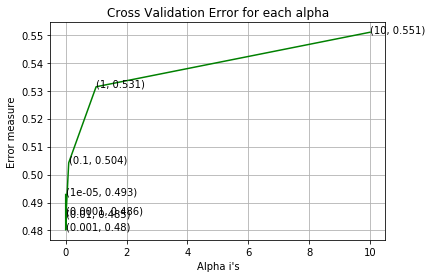

For values of best alpha =  0.001 The train log loss is: 0.4792286155567768
Total number of data points : 2345796


In [116]:
# Traning and Tesing

# Training, use prepared data to train the model.
alpha = [10 ** x for x in range(-5, 2)] # hyperparam for SGD classifier.
y_train_model_1 = y_train
y_train_splited_model_1 = y_train_splited
y_test_splited_model_1 = y_test_splited

# read more about SGDClassifier() at http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html
# ------------------------------
# default parameters
# SGDClassifier(loss=’hinge’, penalty=’l2’, alpha=0.0001, l1_ratio=0.15, fit_intercept=True, max_iter=None, tol=None, 
# shuffle=True, verbose=0, epsilon=0.1, n_jobs=1, random_state=None, learning_rate=’optimal’, eta0=0.0, power_t=0.5, 
# class_weight=None, warm_start=False, average=False, n_iter=None)

# some of methods
# fit(X, y[, coef_init, intercept_init, …])	Fit linear model with Stochastic Gradient Descent.
# predict(X)	Predict class labels for samples in X.

log_error_array=[]
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l2', loss='log', random_state=42)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(x_train_splited_model_1, y_train_splited_model_1)
    predict_y = sig_clf.predict_proba(x_test_splited_model_1)
    log_error_array.append(log_loss(y_test_splited_model_1, predict_y, eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_test_splited_model_1, predict_y, eps=1e-15))

fig, ax = plt.subplots()
ax.plot(alpha, log_error_array,c='g')
for i, txt in enumerate(np.round(log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


# Testing, Use whole training data and whole test data
best_alpha = np.argmin(log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(x_train_model_1, y_train_model_1)

predict_y = sig_clf.predict_proba(x_train_model_1)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train_model_1, predict_y,eps=1e-15))
y_predict_model_1 = sig_clf.predict_proba(x_test_model_1)
y_predict_model_1_max =np.argmax(y_predict_model_1,axis=1)
print("Total number of data points :", len(y_predict_model_1_max))
# plot_confusion_matrix(y_test, predicted_y)


In [117]:
y_predict_model_1_final = y_predict_model_1[:,1]
y_predict_model_1_final

array([0.15420525, 0.52309526, 0.70979283, ..., 0.02388547, 0.73646388,
       0.2878648 ])

In [118]:
y_predict_model_1_max

array([0, 1, 1, ..., 0, 1, 0])

In [119]:
# Make a submission for model

df = pd.read_csv('Data/sample_submission.csv')
df.head()

,test_id,is_duplicate
0,0,1
1,1,1
2,2,1
3,3,1
4,4,1


In [120]:
df.shape

(2345796, 2)

In [121]:
df['is_duplicate'] = y_predict_model_1_final
df.to_csv('Models/qqp_linear_1.csv', index=False)

#### Optimized Method:
- Model 1-1: To find the best parameter, i did lots of fine-tuning on alpha, the process are recorded on, only show the final results below. `scored:0.423`
- Model 1-2: To find the best linear model, i did some experiments on parameters of SGDClassifier like penalty, loss, etc, the process are recorded on, not better than previous ones. `Scored:0.425`

In [122]:
# Optimized Model 1
# Preparation: apply scaling to train and test data

from sklearn.preprocessing import StandardScaler

scale = StandardScaler()
x_train_model_1_1 = scale.fit_transform(x_train)
x_test_model_1_1 = scale.transform(x_test)

x_train_splited_model_1_1 = scale.fit_transform(x_train_splited)
x_test_splited_model_1_1 = scale.transform(x_test_splited)


For values of alpha =  0.00054 The log loss is: 0.4796416911909654
For values of alpha =  0.00054 The log loss is: 0.4796416911909654
For values of alpha =  0.00054 The log loss is: 0.4796416911909654
For values of alpha =  0.00054 The log loss is: 0.4796416911909654
For values of alpha =  0.00055 The log loss is: 0.47962879583799656
For values of alpha =  0.00055 The log loss is: 0.47962879583799656
For values of alpha =  0.00055 The log loss is: 0.47962879583799656
For values of alpha =  0.00055 The log loss is: 0.47962879583799656
For values of alpha =  0.00055 The log loss is: 0.47962879583799656
For values of alpha =  0.00055 The log loss is: 0.47962879583799656
For values of alpha =  0.00055 The log loss is: 0.47962879583799656
For values of alpha =  0.00055 The log loss is: 0.47962879583799656
For values of alpha =  0.00055 The log loss is: 0.47962879583799656
For values of alpha =  0.00055 The log loss is: 0.47962879583799656
For values of alpha =  0.00055 The log loss is: 0.47

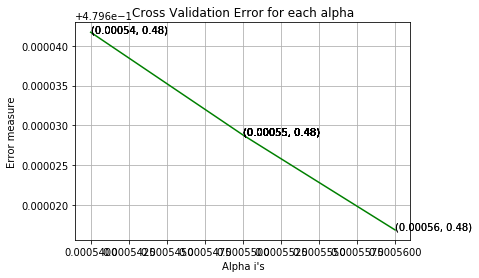

For values of best alpha =  0.00056 The train log loss is: 0.47979159467817944
Total number of data points : 2345796


In [123]:
# Training and Testing

# prepare data for this model
y_train_model_1_1 = y_train
y_train_splited_model_1_1 = y_train_splited
y_test_splited_model_1_1 = y_test_splited


# Training, use prepared data to do the training.
np.random.seed(25)
alpha = np.random.uniform(0.00054 ,0.00056,20)   # 0.00055,0.00065
alpha = np.round(alpha,5)
alpha.sort()
log_error_array=[]
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l2', loss='log', random_state=42)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(x_train_splited_model_1_1, y_train_splited_model_1_1)
    predict_y = sig_clf.predict_proba(x_test_splited_model_1_1)
    log_error_array.append(log_loss(y_test_splited_model_1_1, predict_y,eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_test_splited_model_1_1, predict_y,eps=1e-15))

fig, ax = plt.subplots()
ax.plot(alpha, log_error_array,c='g')
for i, txt in enumerate(np.round(log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


# Testing: Use the best parameter to predict test data:
best_alpha = np.argmin(log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(x_train_model_1_1, y_train_model_1_1)

predict_y = sig_clf.predict_proba(x_train_model_1_1)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train_model_1_1, predict_y,eps=1e-15))
y_predict_model_1_1 = sig_clf.predict_proba(x_test_model_1_1)
y_predict_model_1_1_max =np.argmax(y_predict_model_1_1,axis=1)
print("Total number of data points :", len(y_predict_model_1_1_max))


In [124]:
# Make a submission

y_predict_model_1_1_final = y_predict_model_1_1[:,1]
df = pd.read_csv('Data/sample_submission.csv')
df['is_duplicate'] = y_predict_model_1_1_final
df.to_csv('Models/qqp_linear_2.csv', index=False)


In [125]:
# Optimized Model 2, change the loss and the regularization type, this makes it SVM(right?)
# Preparation: Apply scaling to train and test data

from sklearn.preprocessing import StandardScaler

scale = StandardScaler()
x_train_model_1_2 = scale.fit_transform(x_train)
x_test_model_1_2 = scale.transform(x_test)

x_train_splited_model_1_2 = scale.fit_transform(x_train_splited)
x_test_splited_model_1_2 = scale.transform(x_test_splited)


For values of alpha =  0.00061 The log loss is: 0.4844390220552555
For values of alpha =  0.00062 The log loss is: 0.4843559073443489
For values of alpha =  0.00066 The log loss is: 0.4840140848484696
For values of alpha =  0.00069 The log loss is: 0.4839310763760267
For values of alpha =  0.00078 The log loss is: 0.48370262529556696
For values of alpha =  0.00083 The log loss is: 0.4840309247827417
For values of alpha =  0.00087 The log loss is: 0.48281264143389374
For values of alpha =  0.00087 The log loss is: 0.48281264143389374
For values of alpha =  0.0009 The log loss is: 0.482898786033406
For values of alpha =  0.00091 The log loss is: 0.48283334973628517
For values of alpha =  0.00094 The log loss is: 0.4823173684610036
For values of alpha =  0.00095 The log loss is: 0.4822844024482512
For values of alpha =  0.00102 The log loss is: 0.48264933414076744
For values of alpha =  0.00106 The log loss is: 0.48268480941542
For values of alpha =  0.00108 The log loss is: 0.48263226735

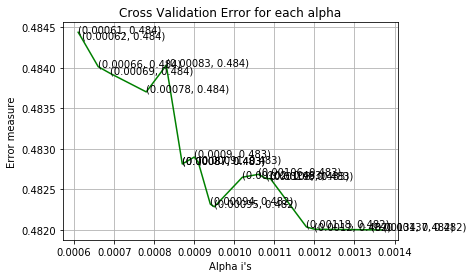

For values of best alpha =  0.00137 The train log loss is: 0.4826850291603913
Total number of data points : 2345796


In [126]:
# Training and Testing

# Prepare data for the model
y_train_model_1_2 = y_train
y_train_splited_model_1_2 = y_train_splited
y_test_splited_model_1_2 = y_test_splited


# Training, use prepared data to train the model
np.random.seed(25)
alpha = np.random.uniform(0.0005 ,0.0015, 20)   # 0.00055,0.00065
alpha = np.round(alpha,5)
alpha.sort()
log_error_array=[]
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l2', loss='hinge', random_state=42)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(x_train_splited_model_1_2, y_train_splited_model_1_2)
    predict_y = sig_clf.predict_proba(x_test_splited_model_1_2)
    log_error_array.append(log_loss(y_test_splited_model_1_2, predict_y,eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_test_splited_model_1_2, predict_y,eps=1e-15))

fig, ax = plt.subplots()
ax.plot(alpha, log_error_array,c='g')
for i, txt in enumerate(np.round(log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


# Testing, use the best parameter to predict test data:
best_alpha = np.argmin(log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='hinge', random_state=42)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(x_train_model_1_2, y_train_model_1_2)

predict_y = sig_clf.predict_proba(x_train_model_1_2)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train_model_1_2, predict_y,eps=1e-15))
y_predict_model_1_2 = sig_clf.predict_proba(x_test_model_1_2)
y_predict_model_1_2_max =np.argmax(y_predict_model_1_2,axis=1)
print("Total number of data points :", len(y_predict_model_1_2_max))



In [127]:
# Make a submission
y_predict_model_1_2_final = y_predict_model_1_2[:,1]
df = pd.read_csv('Data/sample_submission.csv')
df['is_duplicate'] = y_predict_model_1_2_final
df.to_csv('Models/qqp_linear_3.csv', index=False)

### Model_2: Random Forest with Hyperparameter Tuning
I plan to use rf model. `Scored 0.38007, 0.38000`
>**ATTENTION! In fact, the 'Training and Testing' part can be seperated. The former for search the best parameter, and the latter for the model result based on the best para. That saves time for experiments.**

> Okay, I will do it in the process of **CODE ORGANIZING** (PROCESS 3)

In [128]:
# Prepare data for the model
x_train_model_2 = x_train
x_test_model_2 = x_test
x_train_splited_model_2 = x_train_splited
x_test_splited_model_2 = x_test_splited

y_train_model_2 = y_train
y_train_splited_model_2 = y_train_splited
y_test_splited_model_2 = y_test_splited

estimators =  100 Test Log Loss  0.39845190192282465
estimators =  150 Test Log Loss  0.3975388218937196
estimators =  200 Test Log Loss  0.3969507338734131
estimators =  300 Test Log Loss  0.3962759199246605
estimators =  400 Test Log Loss  0.39609464679778994
estimators =  600 Test Log Loss  0.3959015279641766
estimators =  800 Test Log Loss  0.3958018173663114
For values of best estimator =  800 The train log loss is: 0.1145864894102081
Total number of data points : 2345796


Text(0, 0.5, 'Log Loss')

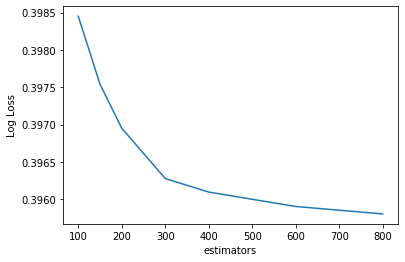

In [129]:
# Training and Testing 

from sklearn.ensemble import RandomForestClassifier as RFC

# Traning, using prepared data
estimators = [100,150,200,300,400,600,800]
test_scores = []
train_scores = []
for i in estimators:
    # Model training
    clf = RFC(n_estimators=i, random_state=32, n_jobs=-1) # n_job=-1 means using all processors
    clf.fit(x_train_splited_model_2,y_train_splited_model_2）
    predict_y = clf.predict_proba(x_test_splited_model_2)
    log_loss_test = log_loss(y_test_splited_model_2, predict_y, eps=1e-15)
    test_scores.append(log_loss_test)
    print('estimators = ',i, 'Test Log Loss ',log_loss_test)

# Testing, using the whole data set    
best_estimator = np.argmin(test_scores) # return the index of the min value
clf = RFC(n_estimators=estimators[best_estimator], random_state=32, n_jobs=-1)
clf.fit(x_train_model_2, y_train_model_2)
predict_y = clf.predict_proba(x_train_model_2)
print('For values of best estimator = ', estimators[best_estimator], "The train log loss is:",
      log_loss(y_train_model_2, predict_y,eps=1e-15))
y_predict_model_2 = clf.predict_proba(x_test_model_2)
y_predict_model_2_max =np.argmax(y_predict_model_2,axis=1)
print("Total number of data points :", len(y_predict_model_2_max))

# Visualization
plt.plot(estimators,test_scores,label='Test Log Loss')
plt.xlabel('estimators')  
plt.ylabel('Log Loss')

In [130]:
y_predict_model_2_final = y_predict_model_2[:,1]
y_predict_model_2_final.shape

(2345796,)

In [131]:
# Make a submission
# y_predict_model_1_2_final = y_predict_model_1_2[:,1]
df = pd.read_csv('Data/sample_submission.csv')
df['is_duplicate'] = y_predict_model_2_final
df.to_csv('Models/qqp_rf_1.csv', index=False)


In [134]:
# I want to see if the loss is smaller at 1000 
# (i.e., the curve is still monotonically decreasing), but I won't increase n_estimators any more  
clf_temp = RFC(n_estimators=1000, random_state=32, n_jobs=-1) # n_job=-1 means using all processors
clf_temp.fit(x_train_splited_model_2,y_train_splited_model_2)
# predict_y = clf.predict_proba(x_train_splited_model_2)
# log_loss_train = log_loss(y_train_splited_model_2, predict_y, eps=1e-15)
# train_scores.append(log_loss_train)
predict_y = clf_temp.predict_proba(x_test_splited_model_2)
temp = log_loss(y_test_splited_model_2, predict_y, eps=1e-15)
temp

0.40236793495520445

- Actually it's better, now i plan to use 1000

#### Optimized Method:
- Model 2-1: try depth fine tuning
- Model 2-2: combine the best ones

In [134]:
# Optimization Model 2-1: try depth fine tuning
# Prepare data for the model
x_train_model_2_1 = x_train
x_test_model_2_1 = x_test
x_train_splited_model_2_1 = x_train_splited
x_test_splited_model_2_1 = x_test_splited

y_train_model_2_1 = y_train
y_train_splited_model_2_1 = y_train_splited
y_test_splited_model_2_1 = y_test_splited

Depth =  50 Test Log Loss  0.3958598896836761
Depth =  65 Test Log Loss  0.39579212619392773
Depth =  80 Test Log Loss  0.3958018173663114
Depth =  100 Test Log Loss  0.3958018173663114
best depth is: 65
For values of best depth =  65 The train log loss is: 0.1145743585123209
Total number of data points : 2345796


Text(0, 0.5, 'Log Loss')

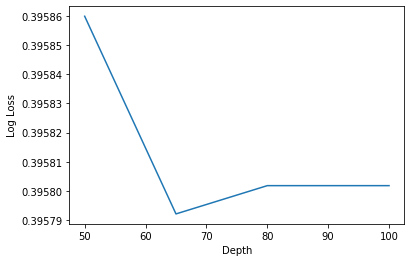

In [135]:
# Training and Testing 

from sklearn.ensemble import RandomForestClassifier as RFC

# Traning, using prepared data
# Depth = [5,10,12,15,20,25,50]
Depth = [50, 65, 80, 100]
# Depth = 
test_scores = []
train_scores = []
for i in Depth:
    # Model training, using the best estimators.
    clf = RFC(n_estimators=800, max_depth=i, random_state=32, n_jobs=-1) # n_job=-1 means using all processors
    clf.fit(x_train_splited_model_2_1,y_train_splited_model_2_1)
    
    predict_y = clf.predict_proba(x_test_splited_model_2_1)
    log_loss_test = log_loss(y_test_splited_model_2_1, predict_y, eps=1e-15)
    test_scores.append(log_loss_test)
    print('Depth = ',i, 'Test Log Loss ',log_loss_test)

# Testing, using the whole data set    
best_depth = np.argmin(test_scores) # return the index of the min value
print('best depth is:', Depth[best_depth])
clf = RFC(n_estimators=800, max_depth=Depth[best_depth], random_state=32, n_jobs=-1)
clf.fit(x_train_model_2_1, y_train_model_2_1)
predict_y = clf.predict_proba(x_train_model_2_1)
print('For values of best depth = ', Depth[best_depth], "The train log loss is:",log_loss(y_train_model_2_1, predict_y,eps=1e-15))
y_predict_model_2_1 = clf.predict_proba(x_test_model_2_1)
y_predict_model_2_1_max =np.argmax(y_predict_model_2_1,axis=1)
print("Total number of data points :", len(y_predict_model_2_1_max))

# Visualization
plt.plot(Depth,test_scores,label='Test Log Loss')
plt.xlabel('Depth')  
plt.ylabel('Log Loss')

Here in the 2nd iteration, i only use parameter{n_estimators=800, depth=65} for 2nd features

In [136]:
# Testing, using the whole data set    
# best_depth = np.argmin(test_scores) # return the index of the min value

print('best depth is:', Depth[best_depth])
clf = RFC(n_estimators=1000, max_depth=65, random_state=32, n_jobs=-1)
clf.fit(x_train_model_2_1, y_train_model_2_1)
predict_y = clf.predict_proba(x_train_model_2_1)
print('For values of best depth = ', Depth[best_depth], "The train log loss is:",log_loss(y_train_model_2_1, predict_y,eps=1e-15))
y_predict_model_2_1 = clf.predict_proba(x_test_model_2_1)
y_predict_model_2_1_max =np.argmax(y_predict_model_2_1,axis=1)
print("Total number of data points :", len(y_predict_model_2_1_max))

best depth is: 65
For values of best depth =  65 The train log loss is: 0.11456674055245297
Total number of data points : 2345796


In [137]:
# Make a submission

y_predict_model_2_1_final = y_predict_model_2_1[:,1]
df = pd.read_csv('Data/sample_submission.csv')
df['is_duplicate'] = y_predict_model_2_1_final
df.to_csv('Models/qqp_rf_2.csv', index=False)

### Model_3: XGBoost with Hyperparameter Tuning
I plan to use xgb model. But my param_dist is just narrow, maybe my teamates can do some parameter fine-tuning for me. `Scored: 0.34376` on xgb_3, currently best model.

- parameter fine tuning refers to: https://blog.csdn.net/u010657489/article/details/51952785, https://www.cnblogs.com/TimVerion/p/11436001.html, https://baijiahao.baidu.com/s?id=1613550753243799306&wfr=spider&for=pc

In [33]:
# Prepare data for the model
x_train_model_3 = x_train
x_test_model_3 = x_test
# x_train_splited_model_3 = x_train_splited
# x_test_splited_model_3 = x_test_splited

y_train_model_3 = y_train
# y_train_splited_model_3 = y_train_splited
# y_test_splited_model_3 = y_test_splited

In [34]:
# Training： nearly 3h to dump process 20min dump

import xgboost as xgb
from scipy.stats import randint
from scipy.stats import uniform
from sklearn.model_selection import RandomizedSearchCV
import pickle

param_dist = {"n_estimators":randint(300,600),
              "learning_rate":uniform(0,0.1),
              "max_depth":randint(4,16),
              "gamma":uniform(0,4),
              "subsample":uniform(0.7,0.3),
              "colsample_bytree": uniform(0.7,0.3),
              "min_child_weight": randint(2, 8),
              "reg_alpha":uniform(100,300),
              "reg_lambda":uniform(100,300)}

xgbclf = RandomizedSearchCV(xgb.XGBClassifier(random_state=25, n_jobs=-1), param_distributions=param_dist,
                                   n_iter=10,scoring='neg_log_loss',cv=5,n_jobs=-1)
xgbclf.fit(x_train_model_3, y_train_model_3)

# store the model
pickle.dump(xgbclf,open('Models/model_xgbclf_4.p','wb'))

# n_iter=10, 

In [35]:
xgbclf.best_estimator_

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.8907752073656516,
              gamma=2.4729845565448296, gpu_id=-1, importance_type='gain',
              interaction_constraints='', learning_rate=0.06563379348627883,
              max_delta_step=0, max_depth=8, min_child_weight=3, missing=nan,
              monotone_constraints='()', n_estimators=582, n_jobs=-1,
              num_parallel_tree=1, objective='binary:logistic', random_state=25,
              reg_alpha=123.14676313765456, reg_lambda=167.05141370916164,
              scale_pos_weight=1, subsample=0.77368152051838,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [36]:
xgbclf.best_params_

{'colsample_bytree': 0.8907752073656516,
 'gamma': 2.4729845565448296,
 'learning_rate': 0.06563379348627883,
 'max_depth': 8,
 'min_child_weight': 3,
 'n_estimators': 582,
 'reg_alpha': 123.14676313765456,
 'reg_lambda': 167.05141370916164,
 'subsample': 0.77368152051838}

In [37]:
xgbclf.best_score_

-0.37418917581723427

In [38]:
xgbclf.refit_time_  # running time: around half an hour, the average time is 40min/model

6358.96234703064

In [39]:
result_dict = xgbclf.cv_results_  # dictionary type

In [40]:
result_dict

{'mean_fit_time': array([13876.04859042, 17283.26502156, 18137.35828924, 27929.8087574 ,
        23197.10313406, 11307.30073338, 13936.06409063, 50496.0764904 ,
        44088.56073585, 20475.93408155]),
 'std_fit_time': array([2.23196965e+01, 7.70159481e+00, 7.48281244e+01, 9.68518147e+01,
        1.56640097e+03, 1.53757897e+03, 2.42763187e+01, 2.31303334e+03,
        3.15510866e+02, 1.39412958e+04]),
 'mean_score_time': array([ 7.72842727,  7.73247561, 10.00022535, 24.85160565, 14.32154403,
         5.94600801,  6.02669239, 13.62627063,  9.86720681,  7.52166696]),
 'std_score_time': array([0.20176414, 0.29866662, 0.688039  , 0.97489443, 0.97865075,
        0.45665529, 0.29715479, 5.73534871, 1.68058318, 4.31987897]),
 'param_colsample_bytree': masked_array(data=[0.8337929281084345, 0.9694738338103441,
                    0.8378884294296214, 0.8462777019992609,
                    0.8907752073656516, 0.700051970645461,
                    0.8816259025246378, 0.9384802916285753,
       

In [41]:
# Choose the best parameters

# gather them to a dataframe for visualization
result_list = []  # record all parameters and scores in n_iters
for item in result_dict['params']:
    para_list = []
    para_list.append(item['n_estimators'])
    para_list.append(item['learning_rate'])
    para_list.append(item['max_depth'])
    para_list.append(item['gamma'])
    para_list.append(item['subsample'])
    para_list.append(item['colsample_bytree'])
    para_list.append(item['min_child_weight'])
    para_list.append(item['reg_alpha'])
    para_list.append(item['reg_lambda'])
    result_list.append(para_list)
result_list_df = pd.DataFrame(result_list,columns=['n_estimators','learning_rate','max_depth','gamma','subsample','colsample_bytree','min_child_weight','reg_alpha','reg_lambda'])
    
result_list_df['mean_test_score'] = result_dict['mean_test_score']
result_list_df['rank_test_score'] = result_dict['rank_test_score']

result_list_df.sort_values('rank_test_score').head(10)


,n_estimators,learning_rate,max_depth,gamma,subsample,colsample_bytree,min_child_weight,reg_alpha,reg_lambda,mean_test_score,rank_test_score
4,582,0.065634,8,2.472985,0.773682,0.890775,3,123.146763,167.051414,-0.374189,1
0,383,0.075613,8,3.241982,0.808085,0.833793,7,109.563599,205.757266,-0.379481,2
7,493,0.075417,15,3.414963,0.779692,0.938480,3,209.529822,316.462473,-0.379850,3
8,503,0.080476,14,1.823179,0.809861,0.878087,5,294.921202,241.514472,-0.383432,4
9,548,0.069816,11,1.546314,0.845926,0.746190,4,376.937119,163.933867,-0.392167,5
1,481,0.068353,7,2.425373,0.843645,0.969474,3,281.411163,116.803579,-0.392473,6
2,484,0.031055,8,0.336610,0.896990,0.837888,2,214.019610,289.120494,-0.400747,7
5,351,0.073546,7,3.746984,0.803154,0.700052,2,306.652183,217.334240,-0.401226,8
3,528,0.026965,13,0.112842,0.718655,0.846278,3,265.471514,253.917437,-0.402197,9
6,441,0.060270,5,1.378970,0.763345,0.881626,4,331.166192,358.729588,-0.410277,10


#### This is the best score after some experiments

In [44]:
# See the results

import pickle

# load data from pickle file
f = open('Models/model_xgbclf_3.p','rb')
xgbclf_result = pickle.load(f)
xgbclf = xgbclf_result

In [45]:
# Tesing: get the best estimator and predict the test data 11.29

xgbclf_final = xgbclf.best_estimator_
xgbclf_final.fit(x_train_model_3, y_train_model_3)
y_predict_model_3 = xgbclf_final.predict_proba(x_test_model_3)
y_predict_model_3_max =np.argmax(y_predict_model_3,axis=1)
print("Total number of data points :", len(y_predict_model_3_max))
# plot_confusion_matrix(y_test, predicted_y)


Total number of data points : 2345796


In [46]:
# Make a submission

y_predict_model_3_final = y_predict_model_3[:,1]
df = pd.read_csv('Data/sample_submission.csv')
df['is_duplicate'] = y_predict_model_3_final
df.to_csv('Models/qqp_xgb_temp.csv', index=False)


### Model_4: Siamese LSTM

- This part has been moved to files like `lstm.ipynb`, `bilstm.ipynb`, etc.
